In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/bj/g3sgj86961v6pk4hm7rg_mmm0000gn/T/pip-req-build-9mrg50or
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/bj/g3sgj86961v6pk4hm7rg_mmm0000gn/T/pip-req-build-9mrg50or
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

import cv2

In [46]:
# Path to the folder containing images and masks
images_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_image_new"
masks_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_mask_new"

# Desired patch size for smaller images and step size ==> when the image is too big, it divides into smaller "patches" for easier processing
patch_size = 256
step = 256

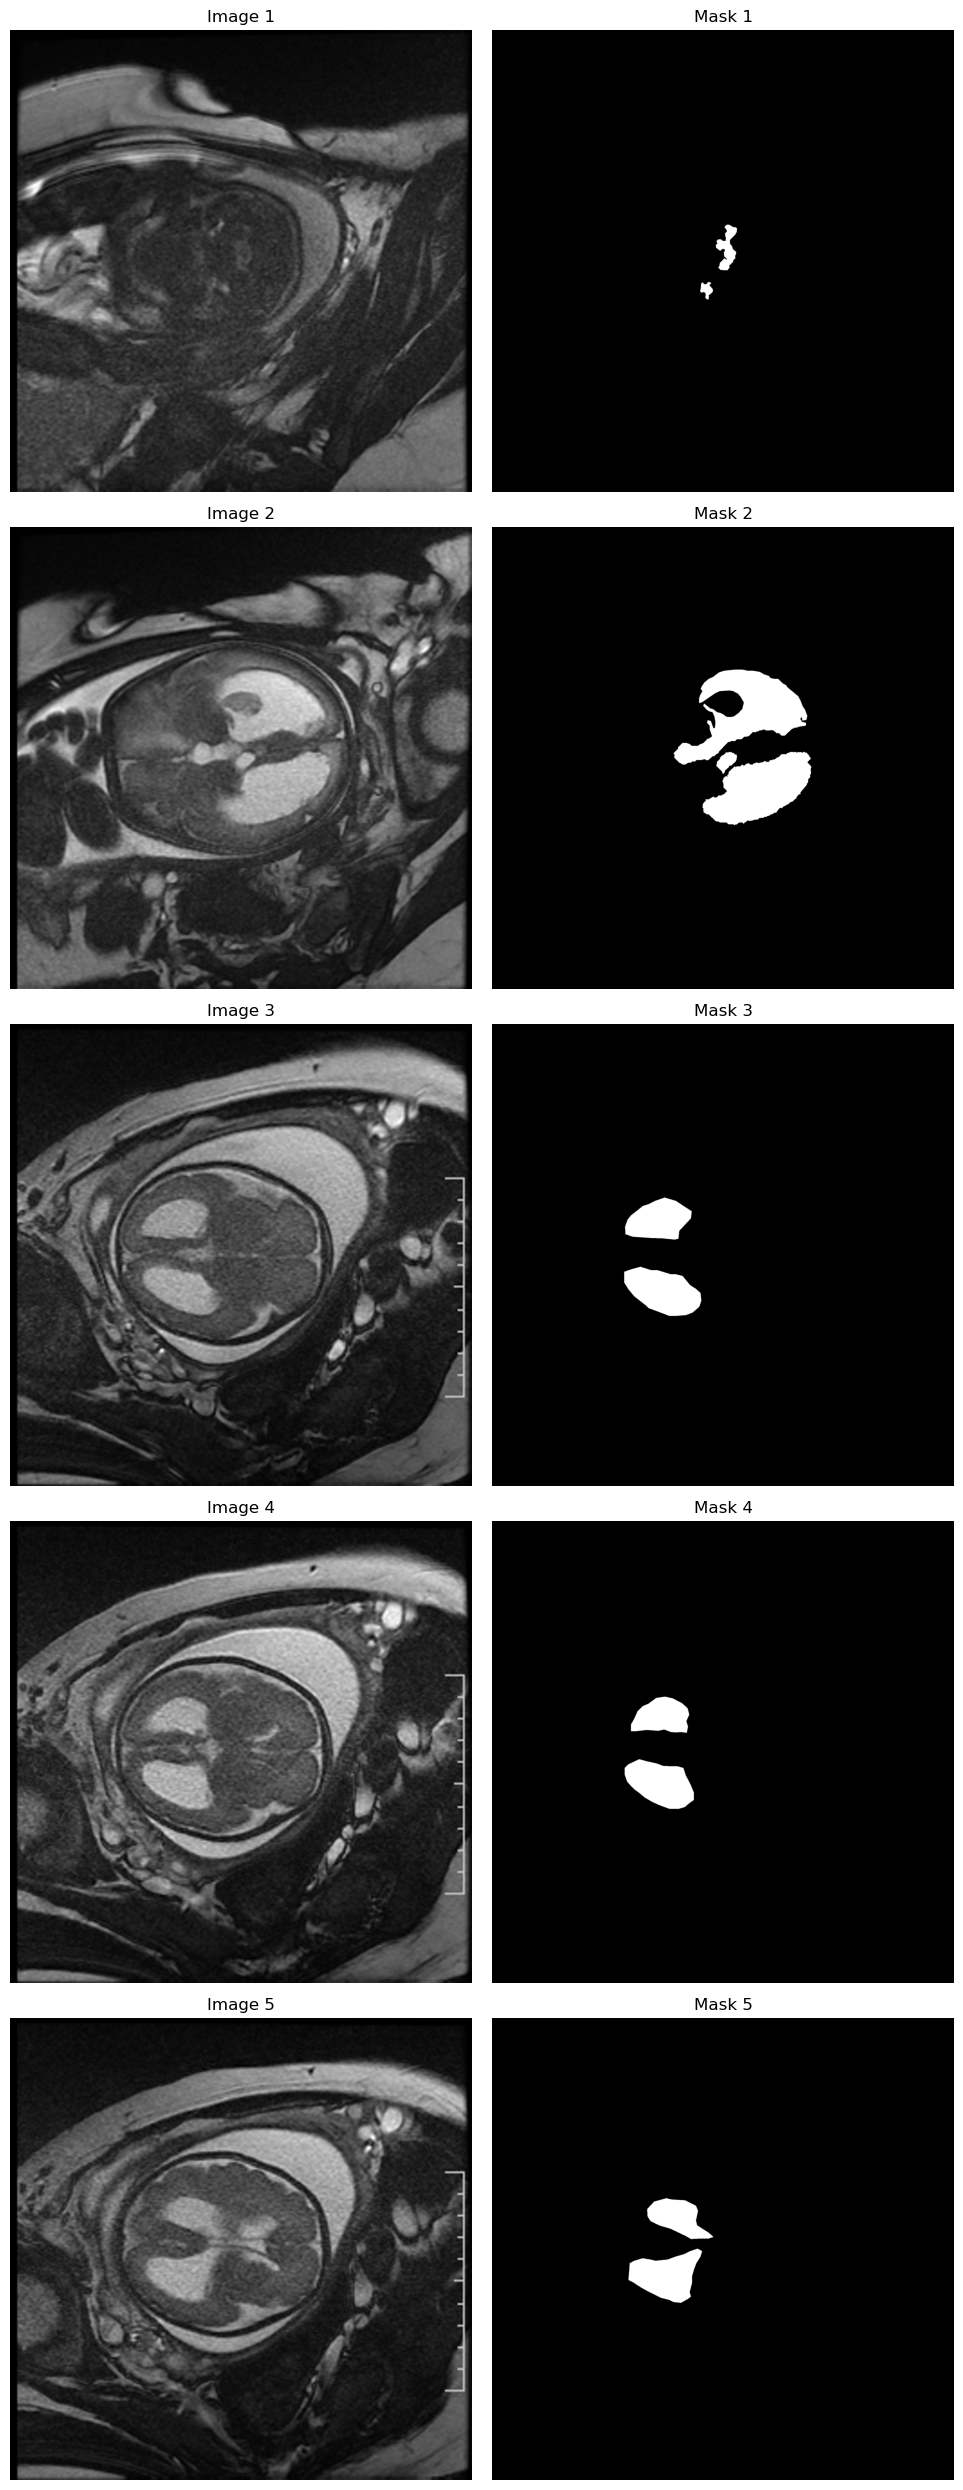

In [47]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):  # Sort to ensure consistent ordering
        if filename.lower().startswith('image') and filename.lower().endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading image '{img_path}': {e}")
    return images

# Function to load masks from a folder
def load_masks_from_folder(folder_path):
    masks = []
    for filename in sorted(os.listdir(folder_path)):  # Sort to ensure consistent ordering
        if filename.lower().startswith('mask') and filename.lower().endswith('.png'):
            mask_path = os.path.join(folder_path, filename)
            try:
                mask = Image.open(mask_path)
                masks.append(mask)
            except Exception as e:
                print(f"Error loading mask '{mask_path}': {e}")
    return masks

# Load images and masks
images_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_image_new"
masks_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_mask_new"
images = load_images_from_folder(images_folder_path)
masks = load_masks_from_folder(masks_folder_path)

# Visualize images and masks to verify correct pairing
def plot_images_and_masks(images, masks):
    num_samples = 5
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        axes[i, 0].imshow(images[i], cmap='gray')  # Assuming images are grayscale
        axes[i, 0].set_title("Image {}".format(i+1))
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='gray')  # Assuming masks are grayscale
        axes[i, 1].set_title("Mask {}".format(i+1))
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot images and masks
plot_images_and_masks(images, masks)


In [48]:
import os
import cv2
import numpy as np
from PIL import Image

def load_images_and_masks_from_folder(images_folder_path, masks_folder_path):
    image_files = os.listdir(images_folder_path)
    mask_files = os.listdir(masks_folder_path)

    # Sort the file lists to ensure images and masks are in the same order
    image_files.sort()
    mask_files.sort()

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        if img_file.endswith(".jpg") or img_file.endswith(".png"):
            image_path = os.path.join(images_folder_path, img_file)
            mask_path = os.path.join(masks_folder_path, mask_file)

            # Load and resize image
            image = cv2.imread(image_path)
            image = resize_image(image, 1024, 768)

            # Load and resize mask
            mask = cv2.imread(mask_path)
            mask = resize_image(mask, 1024, 768)

            images.append(image)
            masks.append(mask)

    return images, masks

def resize_image(image, width, height):
    # Resize using OpenCV
    resized_image = cv2.resize(image, (width, height))
    # Convert back to PIL image
    resized_image_pil = Image.fromarray(resized_image)
    return resized_image_pil

# Define paths to images and masks folders
images_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_image_new"
masks_folder_path = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/ab_mask_new"

# Load images and masks
images, masks = load_images_and_masks_from_folder(images_folder_path, masks_folder_path)

# Now images and masks contain correctly paired image and mask data


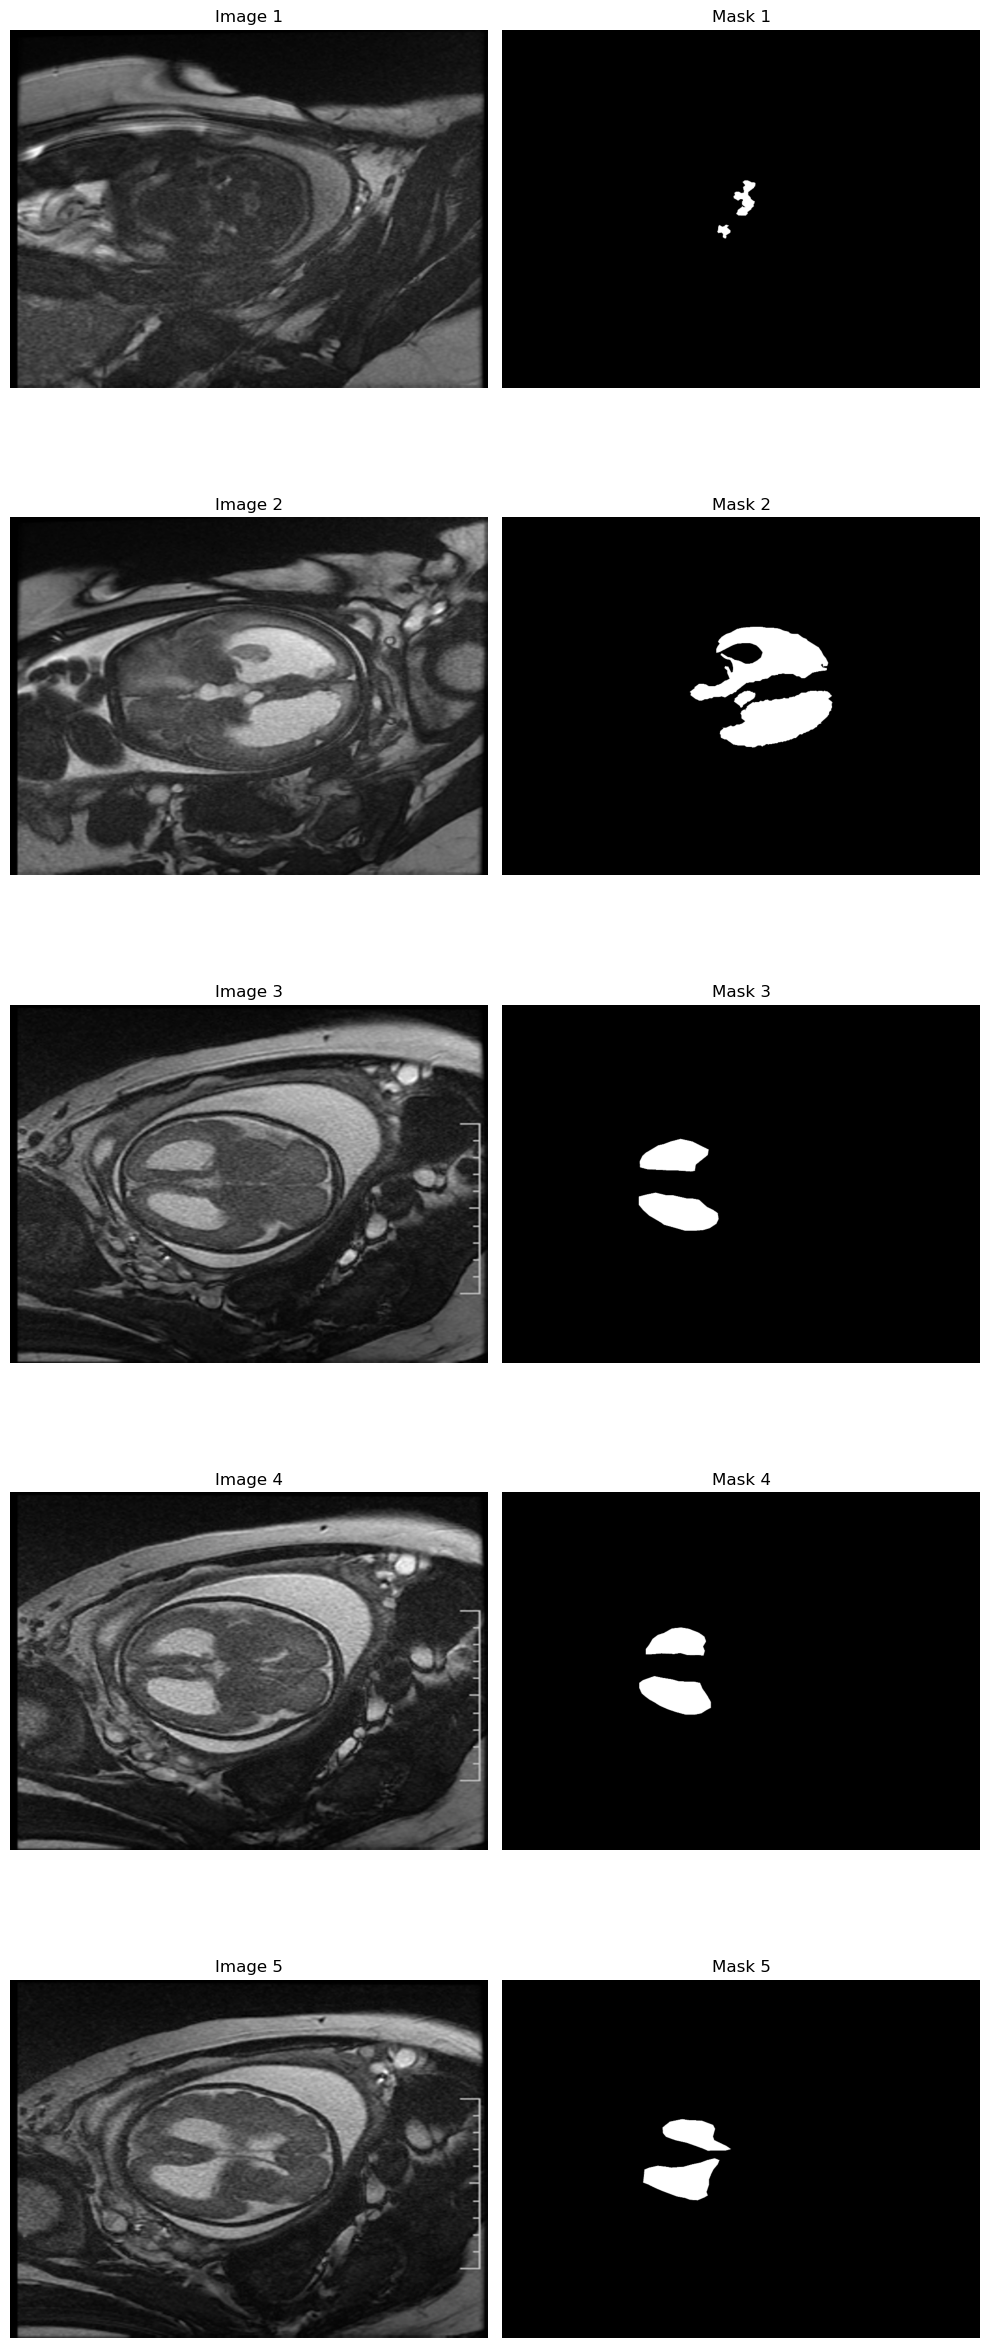

In [49]:
import matplotlib.pyplot as plt

def plot_images_and_masks(images, masks):
    num_samples = 5
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        axes[i, 0].imshow(images[i], cmap='gray')  # Assuming images are grayscale
        axes[i, 0].set_title("Image {}".format(i+1))
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='gray')  # Assuming masks are grayscale
        axes[i, 1].set_title("Mask {}".format(i+1))
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot images and masks
plot_images_and_masks(images, masks)


In [50]:
print(images[0].size)  # Size of the first image
print(masks[0].size)   # Size of the first mask


(1024, 768)
(1024, 768)


In [51]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith((".jpg", ".png")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            resized_image = resize_image(image, 256, 256)
            images.append(resized_image)
    return images

# Function to resize an image
def resize_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

# Load images and masks
images = load_images_from_folder(images_folder_path)
masks = load_images_from_folder(masks_folder_path)

# Check the size of the first image and mask after resizing
print("Image shape after resizing:", images[0].shape)
print("Mask shape after resizing:", masks[0].shape)


Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 3)


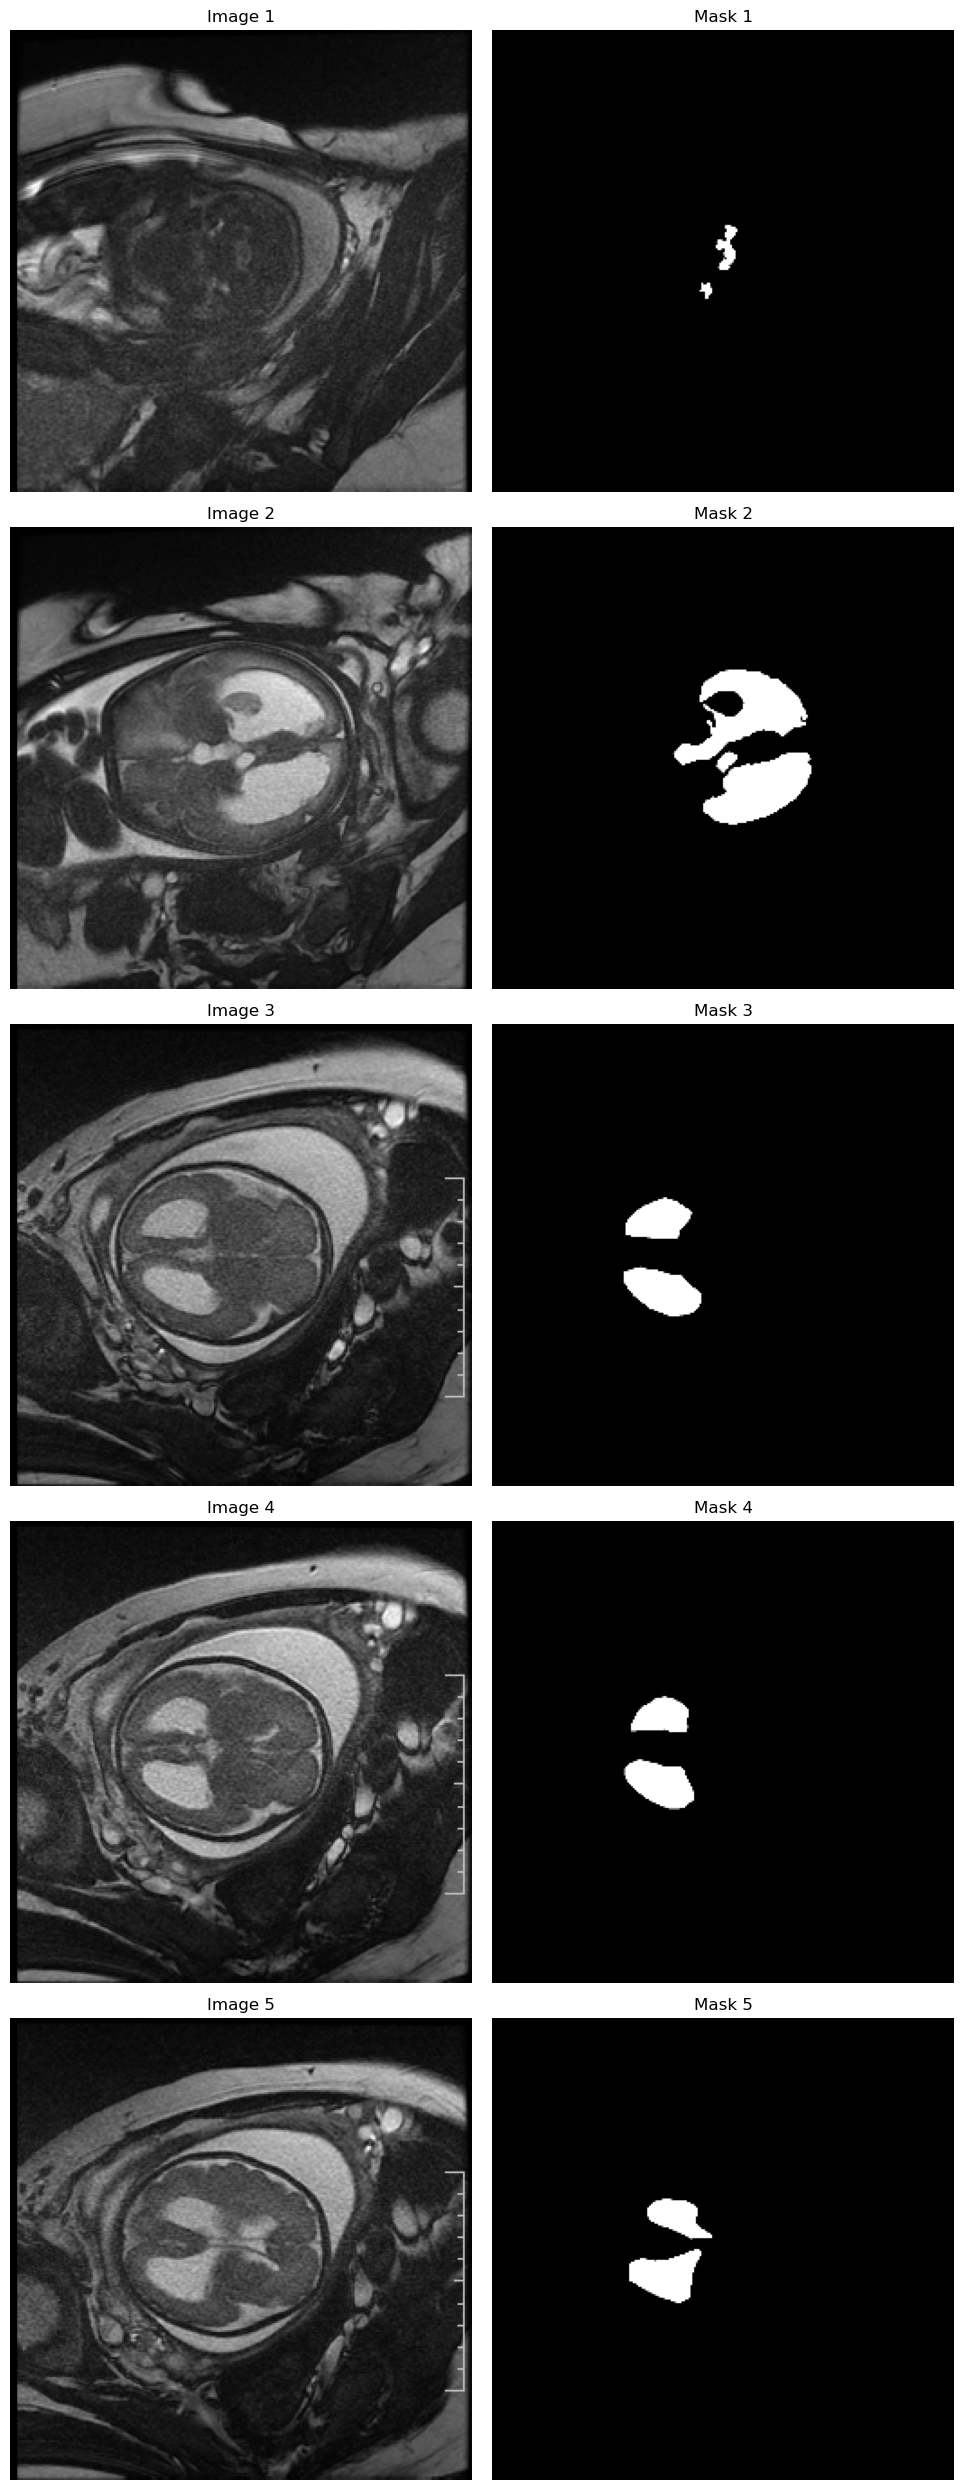

In [53]:
import matplotlib.pyplot as plt

# Function to plot images and masks side by side
def plot_images_and_masks(images, masks):
    num_samples = 5
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        axes[i, 0].imshow(images[i])  # Display image
        axes[i, 0].set_title("Image {}".format(i+1))
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i])  # Display mask
        axes[i, 1].set_title("Mask {}".format(i+1))
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot images and masks
plot_images_and_masks(images, masks)


In [54]:
import numpy as np

# Convert images to numpy array
images_array = np.array([np.array(image) for image in images])

# Convert masks to numpy array
masks_array = np.array([np.array(mask) for mask in masks])

# Check the shapes of the arrays
print("Images array shape:", images_array.shape)
print("Masks array shape:", masks_array.shape)



Images array shape: (125, 256, 256, 3)
Masks array shape: (125, 256, 256, 3)


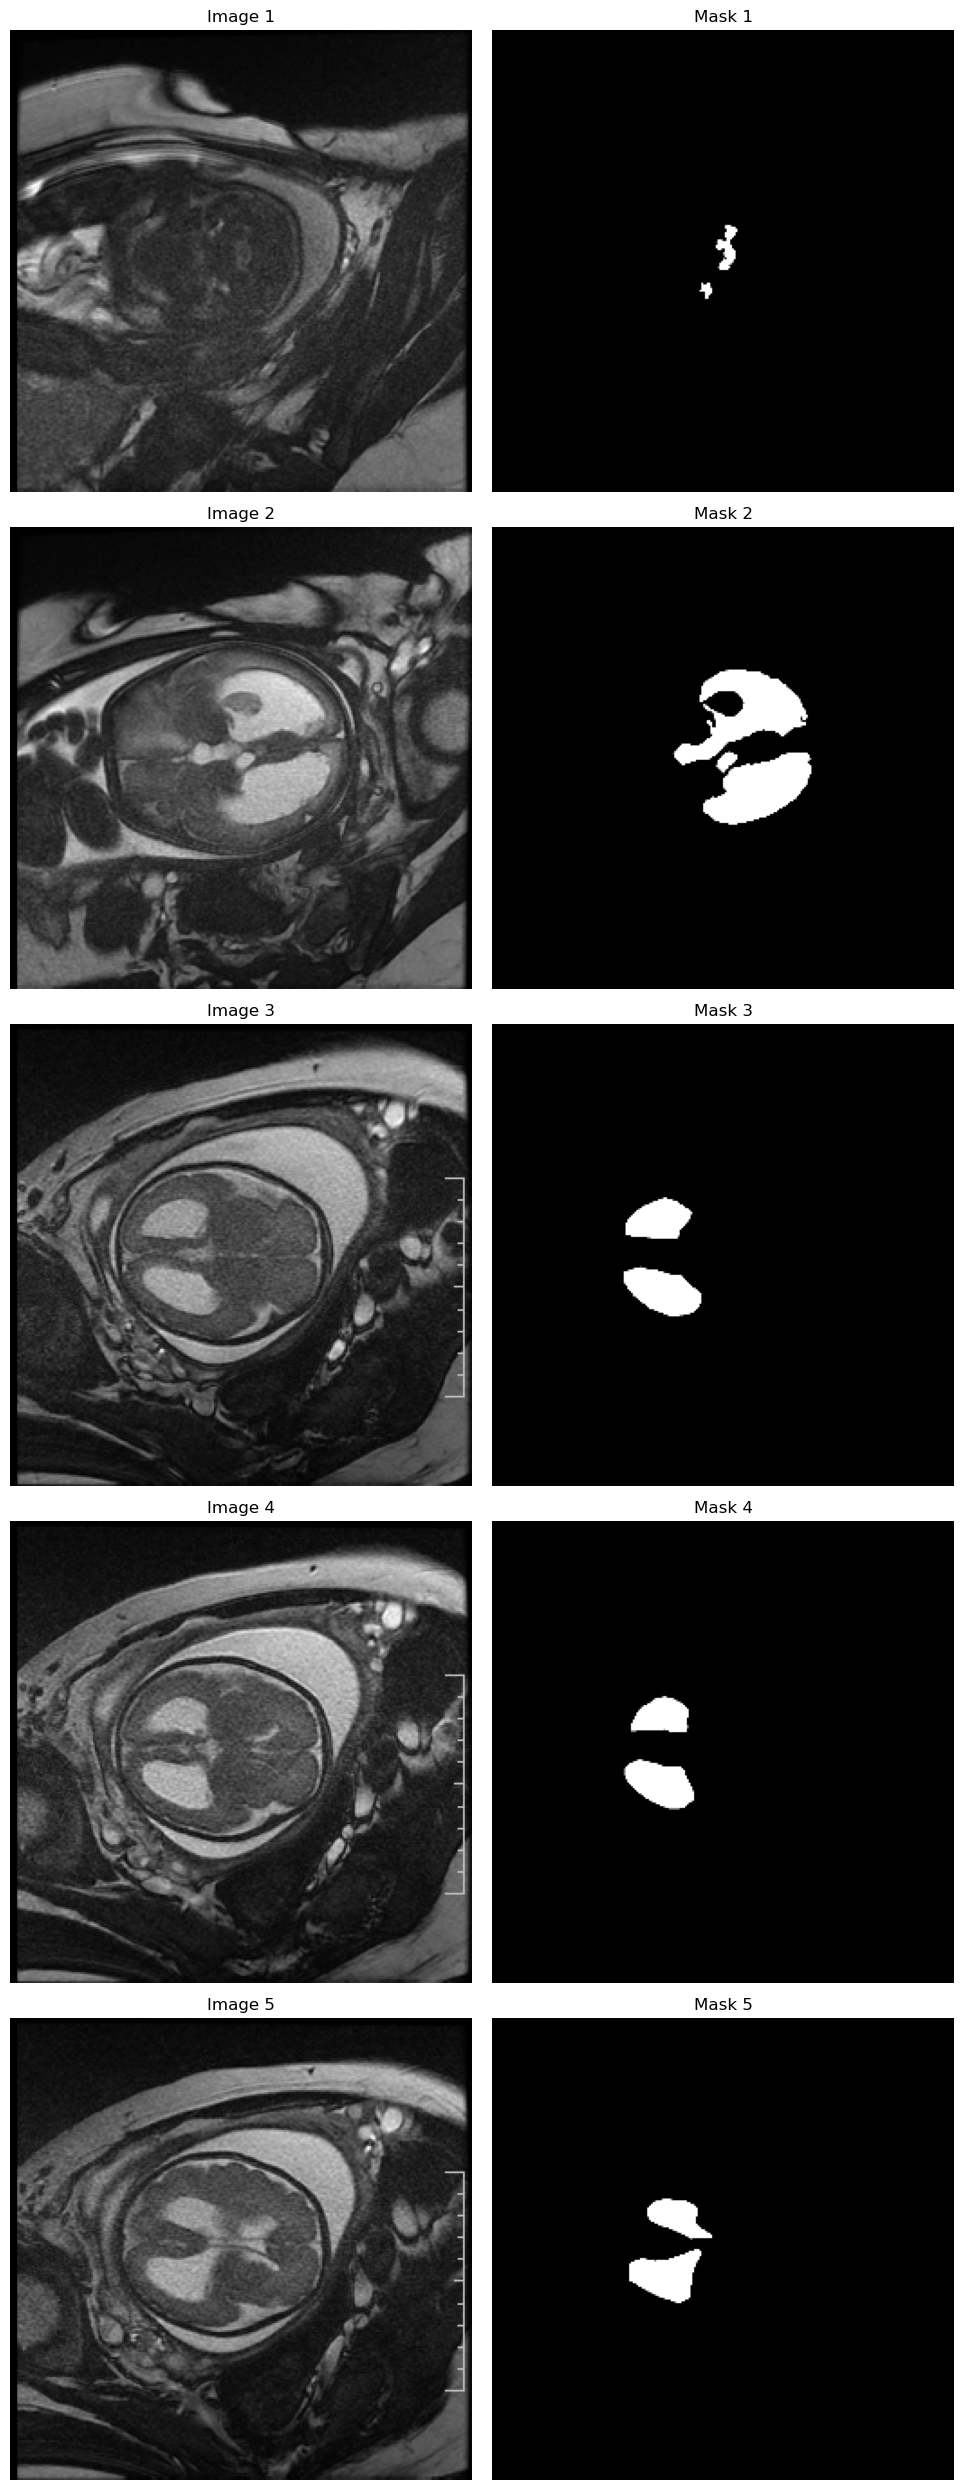

In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            images.append(image)
    return images

# Function to resize images to 256x256
def resize_images(images, width=256, height=256):
    resized_images = [cv2.resize(image, (width, height)) for image in images]
    return resized_images

# Load images and masks
images = load_images_from_folder(images_folder_path)
masks = load_images_from_folder(masks_folder_path)

# Resize images and masks to 256x256
resized_images = resize_images(images)
resized_masks = resize_images(masks)

# Convert resized images and masks to numpy arrays
images_array = np.array(resized_images)
masks_array = np.array(resized_masks)



def visualize_images_and_masks(images, masks, num_samples=5):
    num_samples = min(num_samples, len(images), len(masks))
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title("Image {}".format(i+1))
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title("Mask {}".format(i+1))
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize only 5 images and masks
visualize_images_and_masks(images_array, masks_array, num_samples=5)



In [56]:
from datasets import Dataset
from PIL import Image

import numpy as np

# Make sure both arrays have the same length
assert len(images_array) == len(masks_array), "Number of images and masks should be the same."

# Now you can proceed with creating the dataset
from datasets import Dataset

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_array],
    "label": [Image.fromarray(mask) for mask in masks_array],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [57]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 125
})

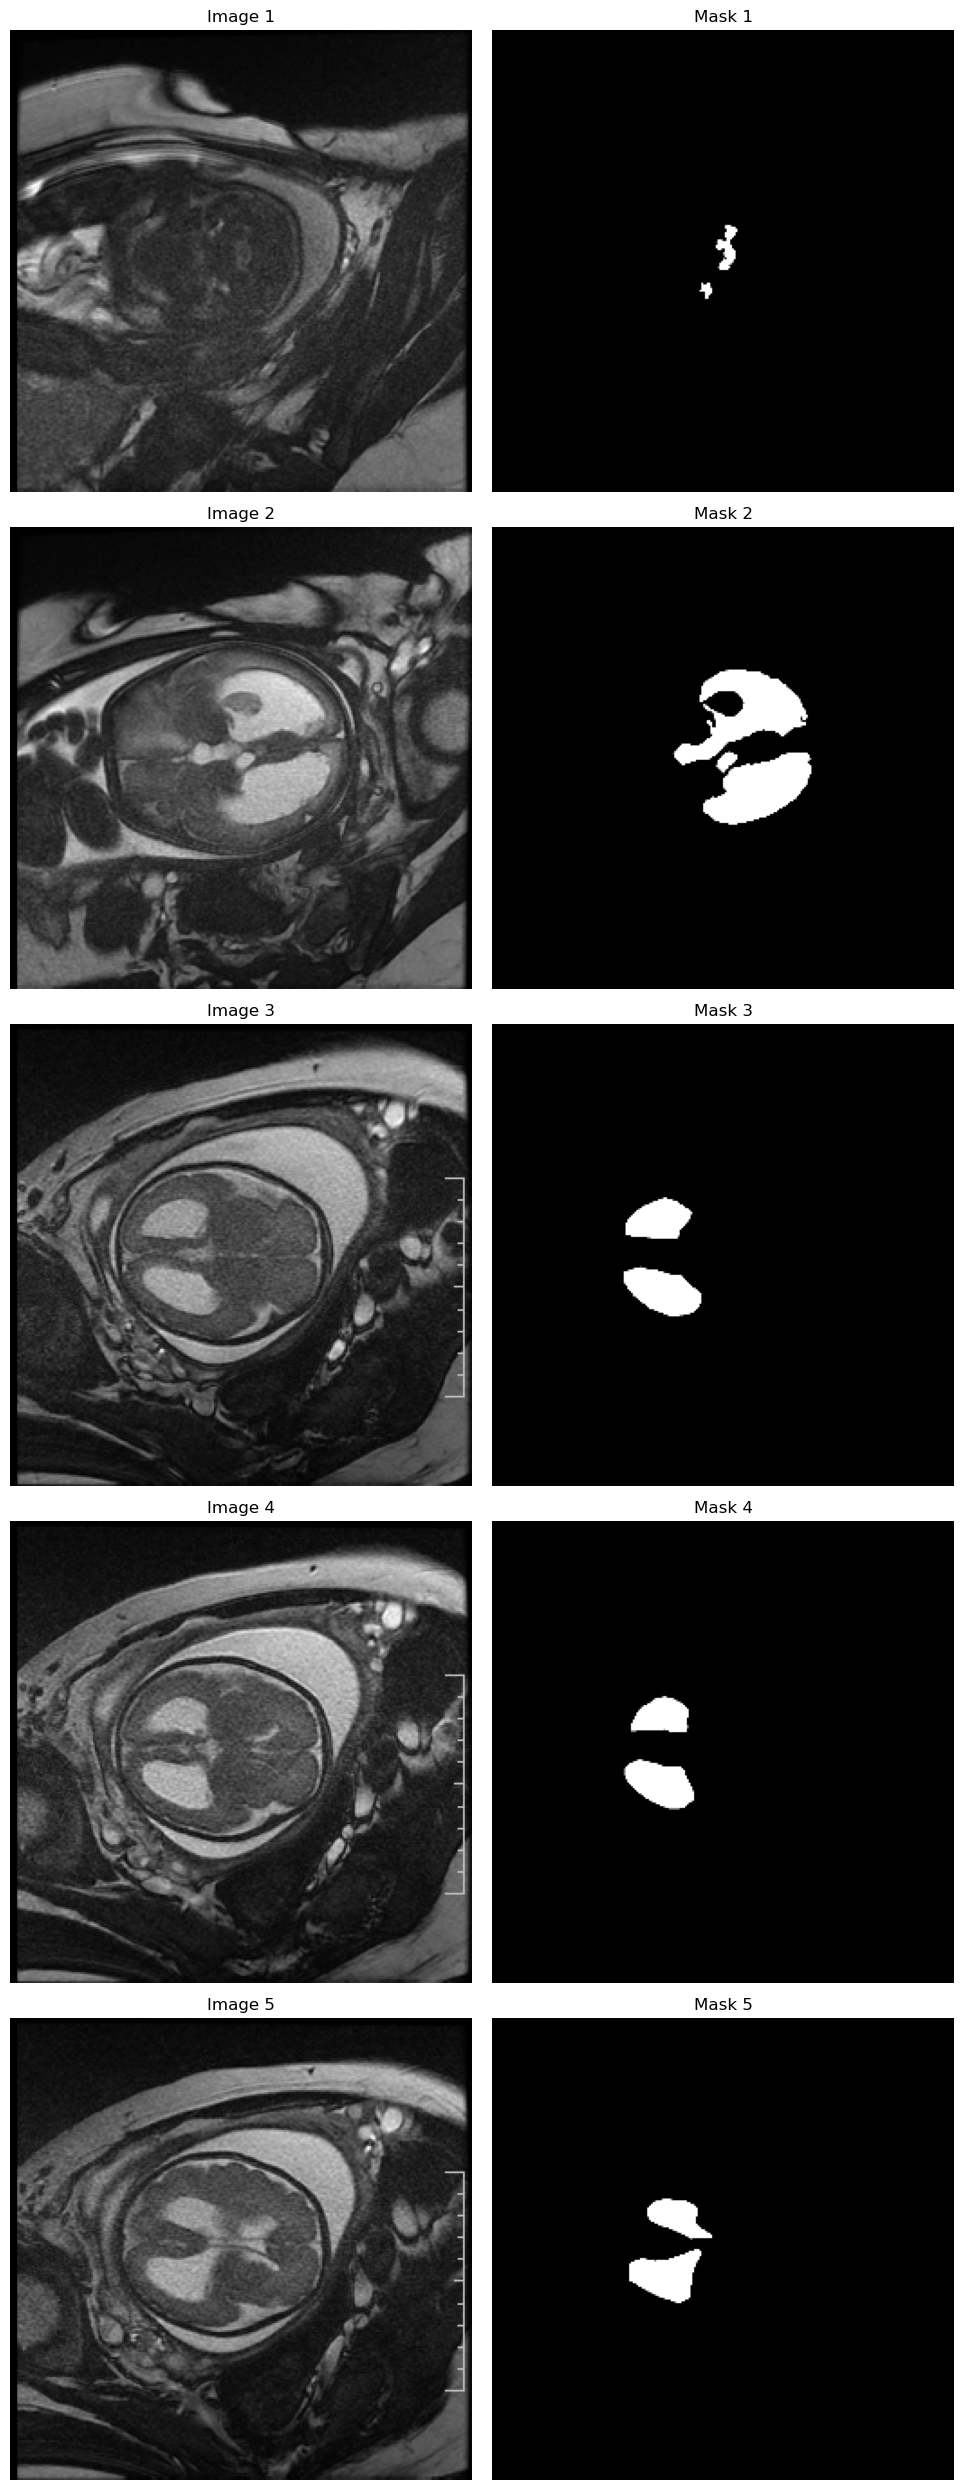

In [58]:
import matplotlib.pyplot as plt

# Define a function to visualize images and masks
def visualize_dataset(dataset, num_samples=5):
    num_samples = min(num_samples, len(dataset))  # Ensure num_samples does not exceed the number of images
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    
    for i in range(num_samples):
        # Get the image and mask for the current sample
        sample = dataset[i]
        image = sample["image"]
        mask = sample["label"]
        
        # Plot the image on the left subplot
        axes[i, 0].imshow(image, cmap='gray')  # Assuming the image is grayscale
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis('off')
        
        # Plot the mask on the right subplot
        axes[i, 1].imshow(mask, cmap='gray')  # Assuming the mask is grayscale
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the dataset
visualize_dataset(dataset)
